In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [ ]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = 'drive/MyDrive'

In [42]:
path = "/Users/sebastianosanson/Development/SB_project/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [ ]:
#### Droppa il primo caso e tiene il secondo con HBOND e VDW

#columns_to_check = df.columns[:-1]
#df_copy = df.copy()
#df = df.drop_duplicates(subset=columns_to_check, keep='last')

In [43]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [44]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_13241/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [45]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [46]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


In [47]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

## Feature engineering


In [ ]:
# Start feature engineering

# Essential: a5_product, a1_product, rsa_sum, sequence_distance.

In [48]:
# Scale all features to the range [0, 1]
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)
input_dim = X_scaled.shape[1]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [50]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

0: 844743
1: 589649
2: 30626
3: 28313
4: 7108
5: 1680
6: 1432
7: 871637


In [ ]:
sampling_strategy = {
    0: 844743,  # HBOND
    1: 589649,  # VDW
    2: 30626,  # PIPISTACK
    3: 50000,  # IONIC
    4: 30000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 871637   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_bal, y_bal = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_bal distribution')
for label in sorted(Counter(y_bal)):
    print(f"{label}: {Counter(y_bal)[label]}")

## 2 - LOAD Existing data


In [ ]:
# X_bal = np.load(path + '/X_bal-SMOTE22.npy')
# y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [ ]:
# print('Original y_train distribution:', Counter(y_train))
# print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# # Count the class in X_bal
# unique_values, counts = np.unique(y_bal, return_counts=True)
# print(dict(zip(unique_values, counts)))

In [ ]:
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

## XGBoost

### Parameters & Helper functions

In [ ]:
params = {
    'device': 'cpu',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 10,
    'learning_rate': 0.2,
    'base_score': 0.5
}

In [ ]:
def feature_importance(model, X_train, y_train):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'
  feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
          't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state'
  ]# Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [ ]:
def compute_metrics(y_test, y_pred, y_pred_prob):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.4f}')
  balanced_acc = balanced_accuracy_score(y_test, y_pred)
  print(f'Balanced Accuracy: {balanced_acc:.4f}')
  auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
  print(f'AUC-ROC: {auc_roc:.4f}')
  mcc = matthews_corrcoef(y_test, y_pred)
  print(f'Matthews Correlation Coefficient: {mcc:.4f}')
  average_precision = average_precision_score(y_test, y_pred_prob, average='weighted')
  print(f'Average Precision Score: {average_precision:.4f}')

In [ ]:
def plot_confusion_matrix(y_test, y_pred, labels):
  cm = confusion_matrix(y_test, y_pred)
  labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
  cm_df = pd.DataFrame(cm, index=labels, columns=labels)

  #plot
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

### Train loop

Training classifier for Class 0
[0]	validation-auc:0.62486
[1]	validation-auc:0.64465
[2]	validation-auc:0.64753
[3]	validation-auc:0.65457
[4]	validation-auc:0.65851
[5]	validation-auc:0.65934
[6]	validation-auc:0.66470
[7]	validation-auc:0.67000
[8]	validation-auc:0.67320
[9]	validation-auc:0.67463
[10]	validation-auc:0.67683
[11]	validation-auc:0.67791
[12]	validation-auc:0.68122
[13]	validation-auc:0.68242
[14]	validation-auc:0.68484
[15]	validation-auc:0.68556
[16]	validation-auc:0.68719
[17]	validation-auc:0.69037
[18]	validation-auc:0.69256
[19]	validation-auc:0.69394
[20]	validation-auc:0.69551
[21]	validation-auc:0.69700
[22]	validation-auc:0.69928
[23]	validation-auc:0.69985
[24]	validation-auc:0.70155
[25]	validation-auc:0.70253
[26]	validation-auc:0.70314
[27]	validation-auc:0.70367
[28]	validation-auc:0.70473
[29]	validation-auc:0.70588
[30]	validation-auc:0.70707
[31]	validation-auc:0.70753
[32]	validation-auc:0.70791
[33]	validation-auc:0.70835
[34]	validation-auc:0.7091

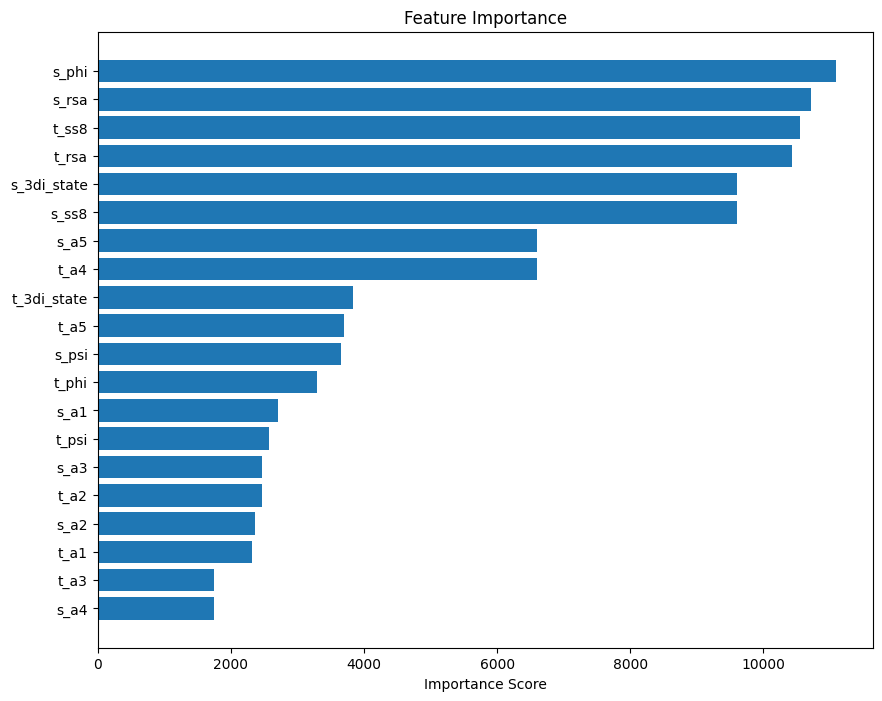

Training classifier for Class 1
[0]	validation-auc:0.54521
[1]	validation-auc:0.54830
[2]	validation-auc:0.54993
[3]	validation-auc:0.55087
[4]	validation-auc:0.55229
[5]	validation-auc:0.55259
[6]	validation-auc:0.55383
[7]	validation-auc:0.55471
[8]	validation-auc:0.55542
[9]	validation-auc:0.55592
[10]	validation-auc:0.55697
[11]	validation-auc:0.55731
[12]	validation-auc:0.55799
[13]	validation-auc:0.55851
[14]	validation-auc:0.55880
[15]	validation-auc:0.55928
[16]	validation-auc:0.55956
[17]	validation-auc:0.55991
[18]	validation-auc:0.56028
[19]	validation-auc:0.56066
[20]	validation-auc:0.56082
[21]	validation-auc:0.56112
[22]	validation-auc:0.56109
[23]	validation-auc:0.56109
[24]	validation-auc:0.56172
[25]	validation-auc:0.56203
[26]	validation-auc:0.56211
[27]	validation-auc:0.56211
[28]	validation-auc:0.56217
[29]	validation-auc:0.56230
[30]	validation-auc:0.56234
[31]	validation-auc:0.56239
[32]	validation-auc:0.56244
[33]	validation-auc:0.56257
[34]	validation-auc:0.5625

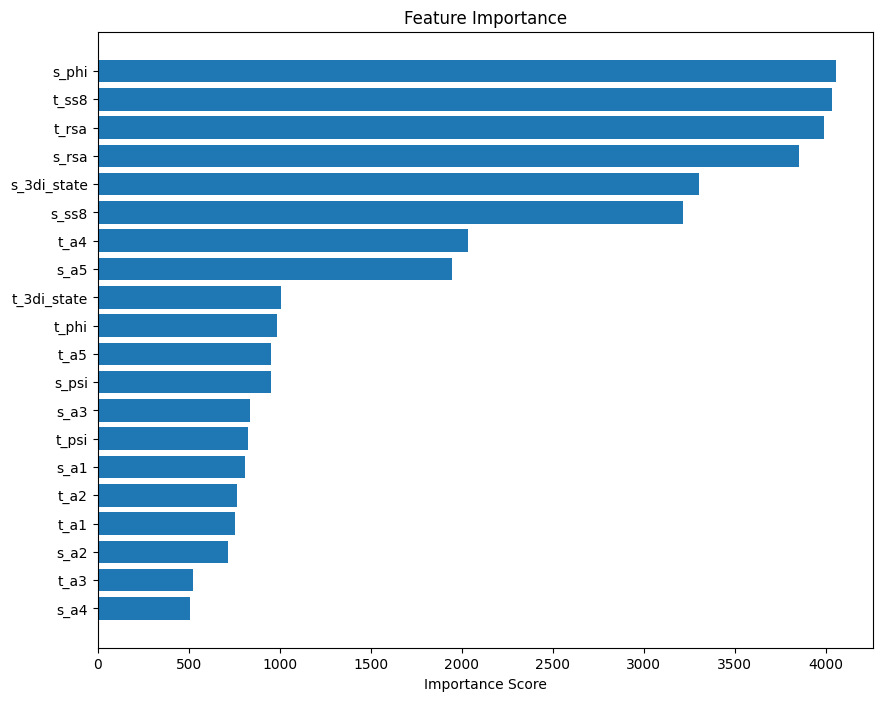

Training classifier for Class 2
[0]	validation-auc:0.99025
[1]	validation-auc:0.99047
[2]	validation-auc:0.99059
[3]	validation-auc:0.99069
[4]	validation-auc:0.99072
[5]	validation-auc:0.99074
[6]	validation-auc:0.99080
[7]	validation-auc:0.99081
[8]	validation-auc:0.99084
[9]	validation-auc:0.99083
[10]	validation-auc:0.99086
[11]	validation-auc:0.99088
[12]	validation-auc:0.99094
[13]	validation-auc:0.99094
[14]	validation-auc:0.99094
[15]	validation-auc:0.99095
[16]	validation-auc:0.99097
[17]	validation-auc:0.99098
[18]	validation-auc:0.99099
[19]	validation-auc:0.99098
[20]	validation-auc:0.99098
[21]	validation-auc:0.99098
[22]	validation-auc:0.99101
[23]	validation-auc:0.99104
[24]	validation-auc:0.99104
[25]	validation-auc:0.99106
[26]	validation-auc:0.99107
[27]	validation-auc:0.99108
[28]	validation-auc:0.99110
[29]	validation-auc:0.99110
[30]	validation-auc:0.99110
[31]	validation-auc:0.99110
[32]	validation-auc:0.99109
[33]	validation-auc:0.99110
[34]	validation-auc:0.9911

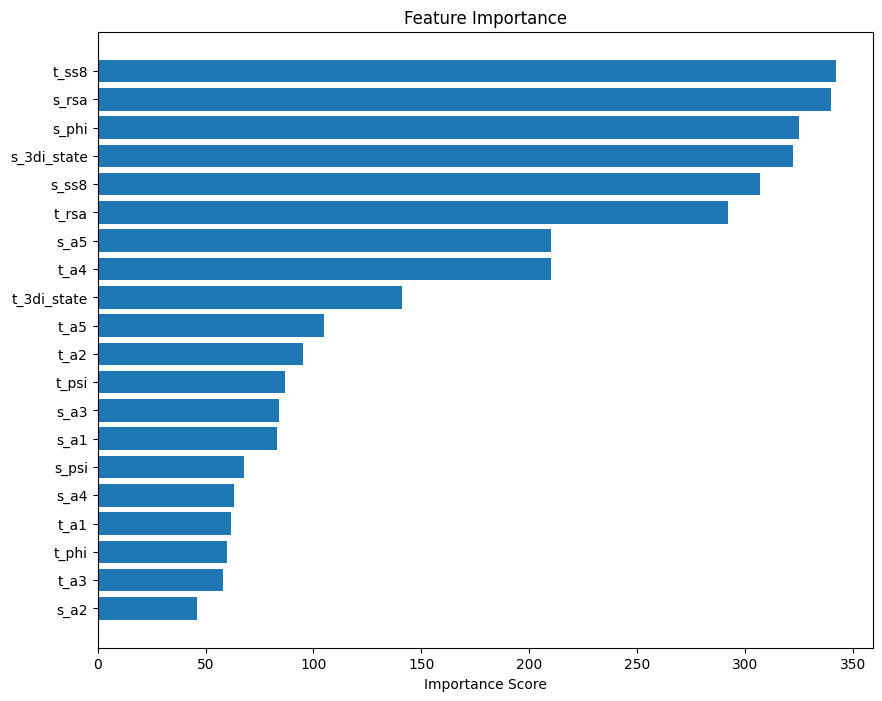

Training classifier for Class 3
[0]	validation-auc:0.97738
[1]	validation-auc:0.97781
[2]	validation-auc:0.97819
[3]	validation-auc:0.97843
[4]	validation-auc:0.97862
[5]	validation-auc:0.97876
[6]	validation-auc:0.97900
[7]	validation-auc:0.97920
[8]	validation-auc:0.97936
[9]	validation-auc:0.97960
[10]	validation-auc:0.97972
[11]	validation-auc:0.97995
[12]	validation-auc:0.98008
[13]	validation-auc:0.98067
[14]	validation-auc:0.98083
[15]	validation-auc:0.98095
[16]	validation-auc:0.98100
[17]	validation-auc:0.98114
[18]	validation-auc:0.98124
[19]	validation-auc:0.98151
[20]	validation-auc:0.98155
[21]	validation-auc:0.98160
[22]	validation-auc:0.98176
[23]	validation-auc:0.98192
[24]	validation-auc:0.98201
[25]	validation-auc:0.98203
[26]	validation-auc:0.98210
[27]	validation-auc:0.98231
[28]	validation-auc:0.98248
[29]	validation-auc:0.98254
[30]	validation-auc:0.98262
[31]	validation-auc:0.98263
[32]	validation-auc:0.98272
[33]	validation-auc:0.98283
[34]	validation-auc:0.9830

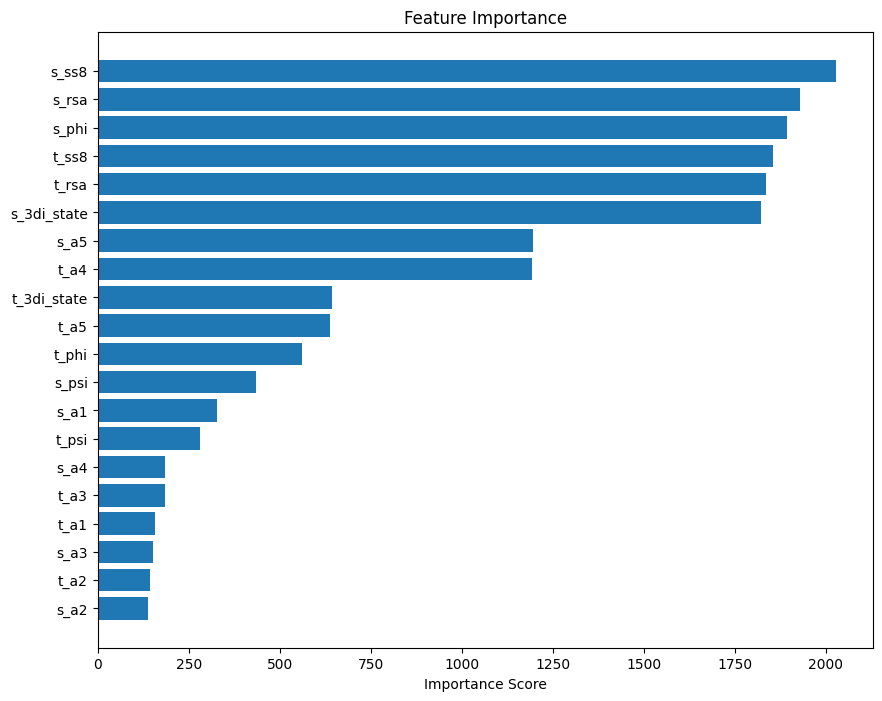

Training classifier for Class 4
[0]	validation-auc:0.99183
[1]	validation-auc:0.99232
[2]	validation-auc:0.99252
[3]	validation-auc:0.99280
[4]	validation-auc:0.99292
[5]	validation-auc:0.99297
[6]	validation-auc:0.99315
[7]	validation-auc:0.99327
[8]	validation-auc:0.99330
[9]	validation-auc:0.99339
[10]	validation-auc:0.99350
[11]	validation-auc:0.99371
[12]	validation-auc:0.99392
[13]	validation-auc:0.99400
[14]	validation-auc:0.99408
[15]	validation-auc:0.99431
[16]	validation-auc:0.99440
[17]	validation-auc:0.99436
[18]	validation-auc:0.99435
[19]	validation-auc:0.99434
[20]	validation-auc:0.99431
[21]	validation-auc:0.99430
[22]	validation-auc:0.99430
[23]	validation-auc:0.99430
[24]	validation-auc:0.99433
[25]	validation-auc:0.99434
[26]	validation-auc:0.99445
[27]	validation-auc:0.99448
[28]	validation-auc:0.99452
[29]	validation-auc:0.99461
[30]	validation-auc:0.99464
[31]	validation-auc:0.99464
[32]	validation-auc:0.99467
[33]	validation-auc:0.99470
[34]	validation-auc:0.9949

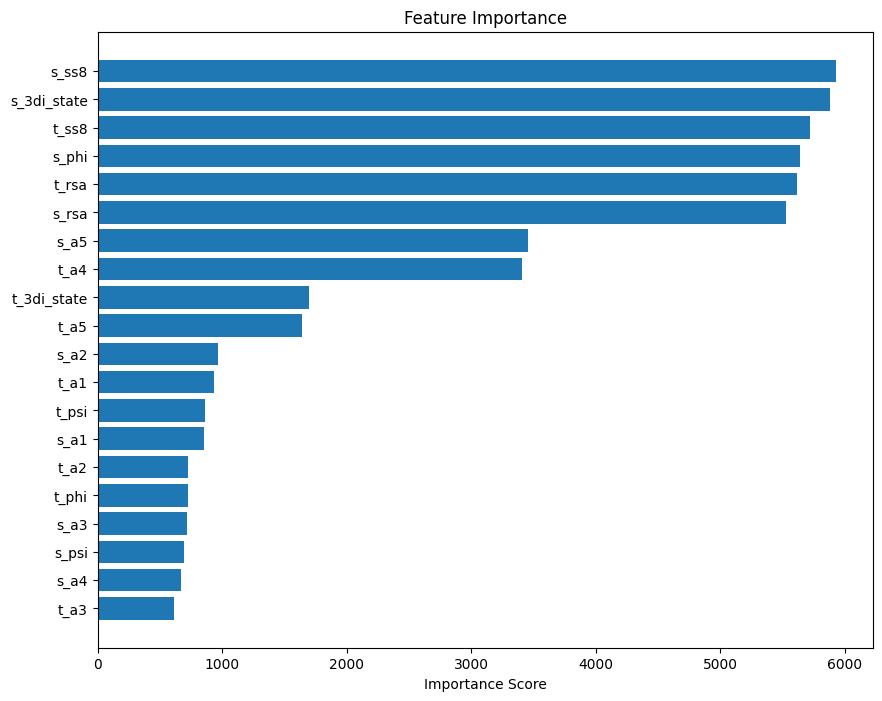

Training classifier for Class 5
[0]	validation-auc:0.99966
[1]	validation-auc:0.99970
[2]	validation-auc:0.99973
[3]	validation-auc:0.99975
[4]	validation-auc:0.99976
[5]	validation-auc:0.99977
[6]	validation-auc:0.99977
[7]	validation-auc:0.99978
[8]	validation-auc:0.99979
[9]	validation-auc:0.99979
[10]	validation-auc:0.99979
[11]	validation-auc:0.99980
[12]	validation-auc:0.99980
[13]	validation-auc:0.99981
[14]	validation-auc:0.99980
[15]	validation-auc:0.99981
[16]	validation-auc:0.99981
[17]	validation-auc:0.99982
[18]	validation-auc:0.99982
[19]	validation-auc:0.99982
[20]	validation-auc:0.99982
[21]	validation-auc:0.99982
[22]	validation-auc:0.99982
[23]	validation-auc:0.99982
[24]	validation-auc:0.99982
[25]	validation-auc:0.99983
[26]	validation-auc:0.99983
[27]	validation-auc:0.99983
[28]	validation-auc:0.99983
[29]	validation-auc:0.99983
[30]	validation-auc:0.99983
[31]	validation-auc:0.99983
[32]	validation-auc:0.99983
[33]	validation-auc:0.99983
[34]	validation-auc:0.9998

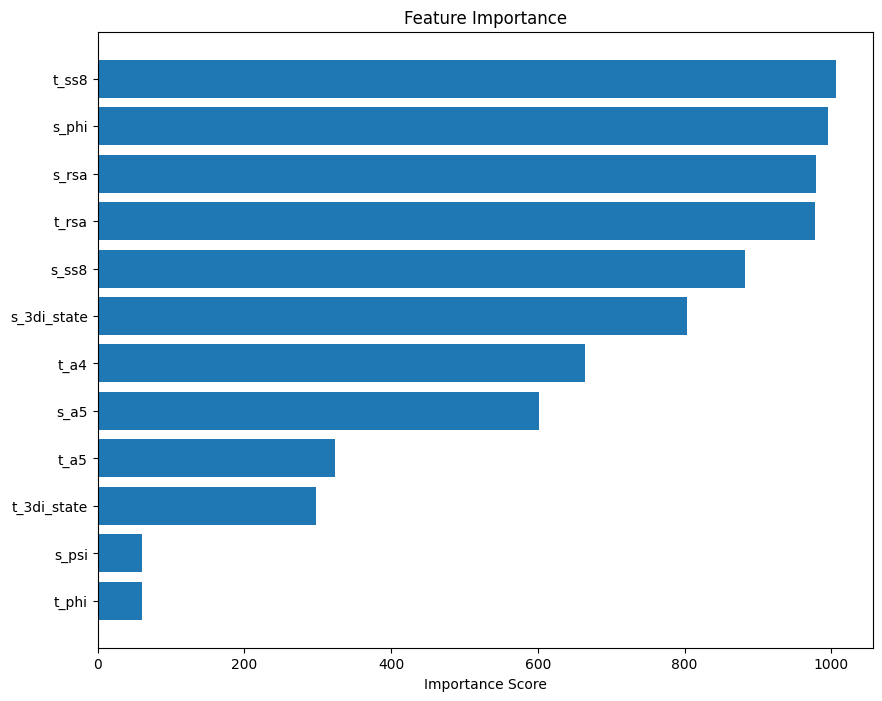

Training classifier for Class 6
[0]	validation-auc:0.95128
[1]	validation-auc:0.95672
[2]	validation-auc:0.96029
[3]	validation-auc:0.96286
[4]	validation-auc:0.96451
[5]	validation-auc:0.96590
[6]	validation-auc:0.96701
[7]	validation-auc:0.96802
[8]	validation-auc:0.97006
[9]	validation-auc:0.97165
[10]	validation-auc:0.97343
[11]	validation-auc:0.97505
[12]	validation-auc:0.97590
[13]	validation-auc:0.97707
[14]	validation-auc:0.97944
[15]	validation-auc:0.98279
[16]	validation-auc:0.98426
[17]	validation-auc:0.98569
[18]	validation-auc:0.98699
[19]	validation-auc:0.98805
[20]	validation-auc:0.98889
[21]	validation-auc:0.98938
[22]	validation-auc:0.98997
[23]	validation-auc:0.99050
[24]	validation-auc:0.99088
[25]	validation-auc:0.99126
[26]	validation-auc:0.99156
[27]	validation-auc:0.99210
[28]	validation-auc:0.99226
[29]	validation-auc:0.99274
[30]	validation-auc:0.99291
[31]	validation-auc:0.99305
[32]	validation-auc:0.99320
[33]	validation-auc:0.99329
[34]	validation-auc:0.9933

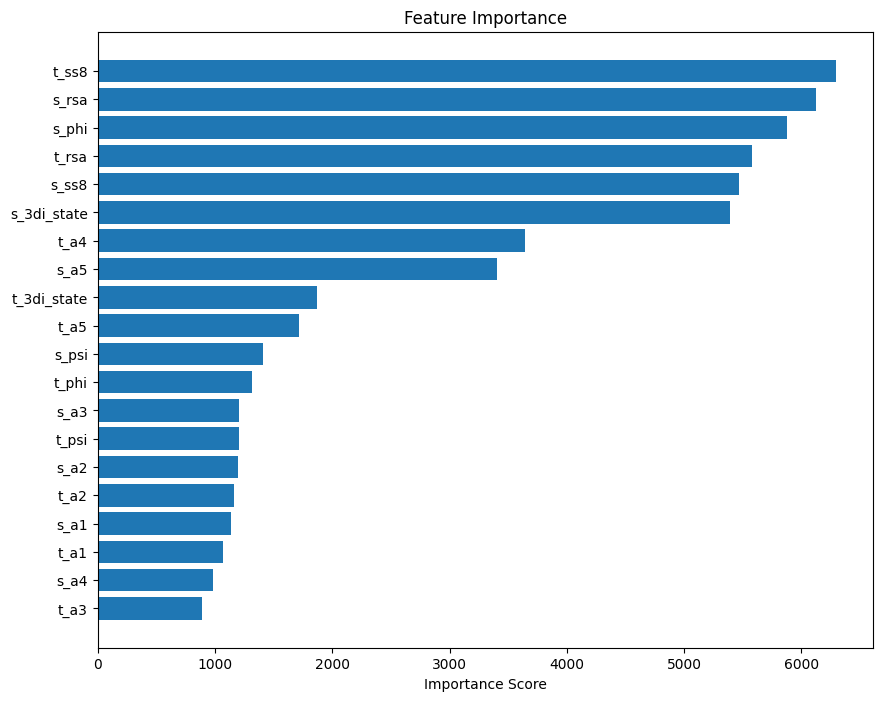

Training classifier for Class 7
[0]	validation-auc:0.66397
[1]	validation-auc:0.67661
[2]	validation-auc:0.68082
[3]	validation-auc:0.68704
[4]	validation-auc:0.68898
[5]	validation-auc:0.69191
[6]	validation-auc:0.69432
[7]	validation-auc:0.69790
[8]	validation-auc:0.69971
[9]	validation-auc:0.70154
[10]	validation-auc:0.70496
[11]	validation-auc:0.70679
[12]	validation-auc:0.70821
[13]	validation-auc:0.71001
[14]	validation-auc:0.71177
[15]	validation-auc:0.71406
[16]	validation-auc:0.71579
[17]	validation-auc:0.71676
[18]	validation-auc:0.71750
[19]	validation-auc:0.71904
[20]	validation-auc:0.72003
[21]	validation-auc:0.72077
[22]	validation-auc:0.72254
[23]	validation-auc:0.72301
[24]	validation-auc:0.72365
[25]	validation-auc:0.72482
[26]	validation-auc:0.72516
[27]	validation-auc:0.72552
[28]	validation-auc:0.72627
[29]	validation-auc:0.72714
[30]	validation-auc:0.72751
[31]	validation-auc:0.72811
[32]	validation-auc:0.72847
[33]	validation-auc:0.72907
[34]	validation-auc:0.7292

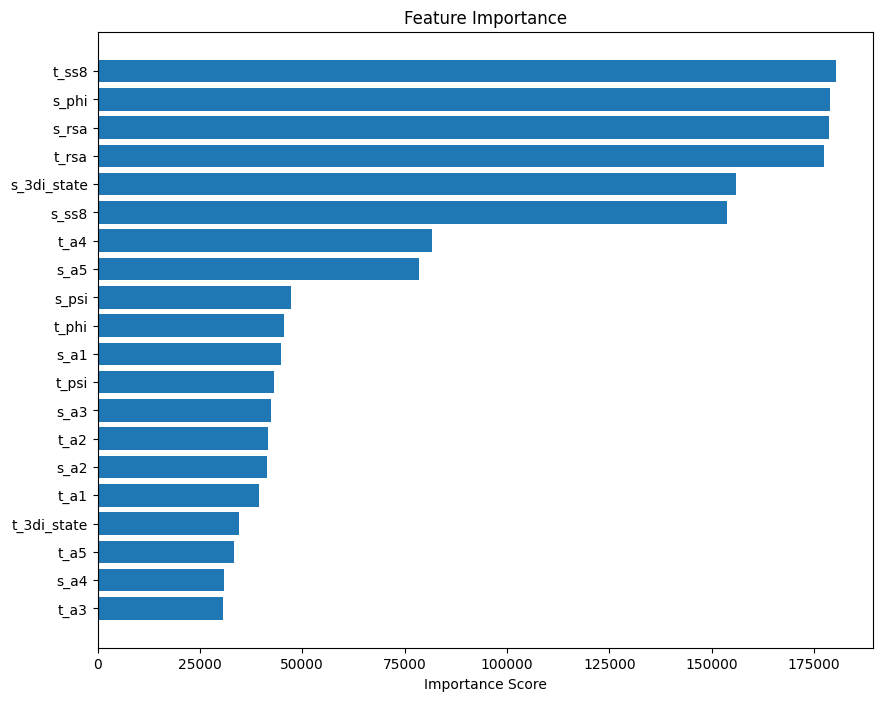


==== Overall Multi-class Performance ====
Accuracy: 0.5409
Balanced Accuracy: 0.4581


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [ ]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_bal))))

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_bal))):
    print(f'Training classifier for Class {num_class}')
    
    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    X_train_binary = X_bal  # Use all balanced training examples
    y_train_binary = (y_bal == num_class).astype(int)
    
    # Split into train/val
    X_train, X_val, y_train_bin, y_val_bin = train_test_split(
        X_train_binary, 
        y_train_binary, 
        test_size=0.2, 
        random_state=42,
        stratify=y_train_binary  # Important for imbalanced data
    )
    
    # Binary labels for test data
    y_test_binary = (y_test == num_class).astype(int)
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_bin)
    dval = xgb.DMatrix(X_val, label=y_val_bin)
    dtest = xgb.DMatrix(X_test, label=y_test_binary)
    
    # Train model
    model = xgb.train(
        params, 
        dtrain, 
        num_boost_round=2500, 
        evals=[(dval, 'validation')], 
        early_stopping_rounds=20
    )
    
    # Save model
    os.makedirs(os.path.join(path, 'models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/xgboost_model_class_{num_class}.json'))
    
    # Store predictions for this class
    y_pred_prob = model.predict(dtest)
    all_class_predictions[:, num_class] = y_pred_prob
    
    # Evaluate this binary classifier
    y_pred = (y_pred_prob > 0.5).astype(int)
    print(f"\nBinary Classification Report for Class {num_class}")
    print(f"Accuracy: {accuracy_score(y_test_binary, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_pred):.4f}")
    
    # Optional: Display feature importance for this classifier
    feature_importance(model, X_train, y_train_bin)
    
    # Store the model
    models.append(model)

# Final multi-class predictions (choose class with highest probability)
# final_predictions = np.argmax(all_class_predictions, axis=1)

# Evaluate overall multi-class performance
# print("\n==== Overall Multi-class Performance ====")
# compute_metrics(y_test, final_predictions, all_class_predictions)
# plot_confusion_matrix(y_test, final_predictions, np.unique(y))